In [ ]:
# Remove this
#! pip install torch==2.3 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip install --upgrade torch torchvision==0.15.0+cu118 --index-url https://download.pytorch.org/whl/cu118

#! pip install stacchip
#! pip install geopandas

! pip install contextily

SyntaxError: invalid syntax (4269583495.py, line 2)

In [1]:

import warnings

import geoarrow.pyarrow as ga
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pystac_client
import requests
import torch
import yaml
from box import Box

import stacchip.indexer
from stacchip.chipper import Chipper
from stacchip.indexer import Sentinel2Indexer
from torchvision.transforms import v2

import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import math
import os
import random

import timm
import torch
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from torch import nn
from torchvision.transforms import v2

from src.backbone import Transformer
from src.factory import DynamicEmbedding
from src.utils import posemb_sincos_2d_with_gsd

torch.set_float32_matmul_precision("medium")
os.environ["TORCH_CUDNN_V8_API_DISABLED"] = "1"

#from src.model import ClayMAEModule

import contextily as cx
import rasterio
from rasterio.plot import show

from shapely.geometry import box

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

#### Load mining data and visualize

In [2]:
# Load mine point data
mine_pts = gpd.read_file('data/pitlakes').to_crs(epsg=4326)

# Print info about dataset
print(mine_pts['Material'].value_counts())
print(len(mine_pts))
print(mine_pts['ID'].value_counts())

Material
coal         27
Al           24
Au           22
limestone    18
diamond      13
Fe           13
U             6
sand          4
phosphate     1
Cu            1
Name: count, dtype: int64
1004
ID
Ridgeway2    1
CC2          1
CC3          1
CC5          1
CC4          1
Pritzen      1
NULL+        1
Name: count, dtype: int64


In [3]:
# Load mine polygons and remove Z coordinate
mine_poly = gpd.read_file('data/mine_poly_shp').to_crs(epsg=4326)

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    From : https://gist.github.com/rmania/8c88377a5c902dfbc134795a7af538d8
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
        else:
            print('no z')
    return new_geo

mine_poly.geometry = convert_3D_2D(mine_poly.geometry) 

print('Number of mine features:')
print(len(mine_poly))


Number of mine features:
74548


<Axes: >

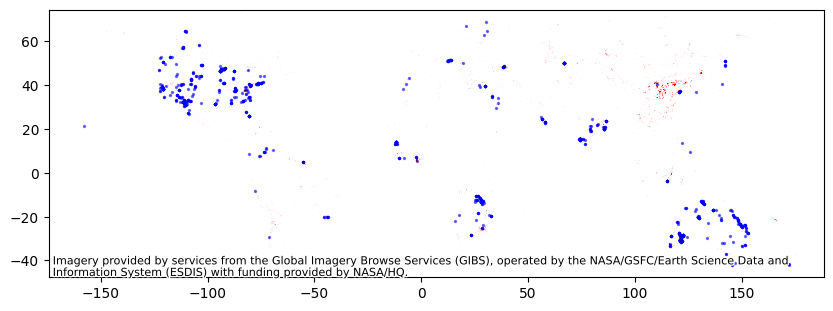

In [37]:
# Visualize with satellite basemap
providers = cx.providers.flatten()

# Visualize mine point data
ax = mine_pts.plot(column = 'Material', 
    markersize = 2,
    color = 'blue', 
    legend = True, 
    legend_kwds={'bbox_to_anchor': (1, 1)},
    figsize = (10,10),
    alpha = 0.5)
cx.add_basemap(ax, crs=mine_pts.crs, source=providers['NASAGIBS.BlueMarble'])

mine_poly.plot(ax=ax, color = 'red', linewidth = 6)

In [7]:
overlap_check = gpd.sjoin(mine_pts, mine_poly, how = 'inner', predicate = "intersects")
print("% of mine pts with overlapping polygon:")
print(len(overlap_check)/len(mine_pts)*100)

% of mine pts with overlapping polygon:
80.57768924302789


In [4]:
# Keep only polygons with confirmed mine point from Aquarry

mine_pts_polys = gpd.sjoin(mine_poly, mine_pts, how = 'inner', predicate = "intersects")

In [5]:
# Get pit lakes in Minnesota

states = gpd.read_file('data/state_boundaries')
mn = states[states['STUSPS']=='MN']
mn = mn.to_crs(epsg = 4326).geometry.unary_union # MN was multipolygon

mn_mines_pts = mine_pts[mine_pts.geometry.within(mn)]
mn_mines_poly = mine_poly[mine_poly.geometry.intersects(mn)]
mn_mines_intersect = mine_pts_polys[mine_pts_polys.geometry.intersects(mn)]

In [6]:
# Get pit lakes in AZ

states = gpd.read_file('data/state_boundaries')
az = states[states['STUSPS']=='AZ']
az = az.to_crs(epsg = 4326).geometry.unary_union # MN was multipolygon

az_mines_pts = mine_pts[mine_pts.geometry.within(az)]
az_mines_poly = mine_poly[mine_poly.geometry.intersects(az)]
az_mines_intersect = mine_pts_polys[mine_pts_polys.geometry.intersects(az)]

#### Visualize Minnesota and Arizona mines

In [ ]:
# Visualize MN pit lakes
ax = mn_mines_intersect.plot()
cx.add_basemap(ax, crs=mn_mines_intersect.crs, source=providers['NASAGIBS.BlueMarble'])

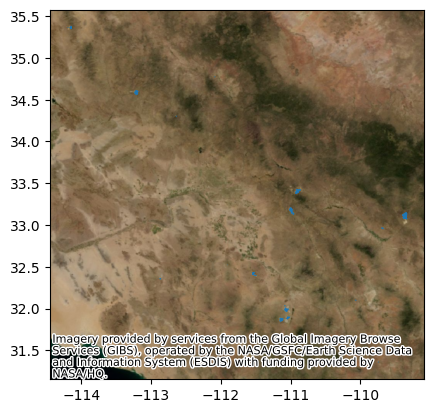

In [ ]:
# Visualize AZ pit lakes

ax = az_mines_intersect.plot()
cx.add_basemap(ax, crs=az_mines_intersect.crs, source=providers['NASAGIBS.BlueMarble'])

#### Get MN waterbody data and separate mines / other bodies of water

In [ ]:
# Data source: https://gisdata.mn.gov/dataset/water-dnr-hydrography

mn_water_features = gpd.read_file('data/dnr_hydro_features')

mine_classes = ['Natural Ore Mine','Mine Pit Lake','Mine Pit Lake (NF)','Tac/Natural Ore Mine']

dnr_pit_lakes = mn_water_features.loc[mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

dnr_water = mn_water_features[~mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

print(len(dnr_pit_lakes))
print(len(dnr_water))

200
130746


<Axes: >

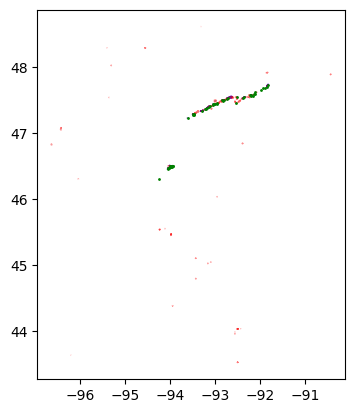

In [ ]:
#Check overlap of Minnesota Aquarry points and DNR polygons

overlap = gpd.sjoin(dnr_pit_lakes,mn_mines_pts,how = "inner",rsuffix="1")

ax = overlap.plot(edgecolor = 'blue')
dnr_pit_lakes.plot(ax=ax,edgecolor = 'red', alpha = 0.5)
mn_mines_pts.plot(ax = ax, color = 'green',markersize = 1)

#### Grab embeddings for mines and random embeddings

In [171]:
# Define function for getting embedding files that intersect with polygons of interest

def GetEmbeddingsFromIntersection(folder_path, polygons, random_images = True):
    """ Take a folder of embeddings as a string and a set of polygons and return 1) image files with intersecting 
    chips and 2) a random set of non-intersecting image files
    
    Parameters:
    folder_path (str): folder with embeddings
    polygons (GeoDataFrame): positive polygon masks 
    random_images (bool): True if you want random negative images
    
    Returns:
    positive_embeddings, negative embeddings (list, list): one positive, one negative set of embedding gpq file names """

    positive_embeddings = []
    negative_embeddings = []
    folders = []

    # Go through all embedding folders
    folder_list = os.listdir(folder_path)

    import random
    count = 0

    # Get list of folders to search through
    for folder in folder_list: 
        folders.append(f"{folder_path}{folder}")

    # In each folder, go through parquet files and add file to list if it contains mines
    for folder in folders: 
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        
        # Set up to get 10 random images
        index = random.randint(0,len(parquet_files)-1)
        random_image = parquet_files[index]

        # Check if image has any intersecting chips
        for file in parquet_files:
            pqs = gpd.read_parquet(file, columns=["geometry"])
            if not gpd.sjoin(pqs, polygons, how="inner", predicate="intersects", rsuffix="_1").empty:
                positive_embeddings.append(file)
            else: 
                if random_images == True: # If there is no intersection, choose ~20 random images to grab embeddings
                    if count < 30:
                        if random.random() < 0.50:
                            if file == random_image:
                                negative_embeddings.append(file)
                                count = count + 1

    return positive_embeddings, negative_embeddings

In [172]:
# Get embeddings for pit lakes and no pit lakes present in AZ

mine_embeddings_az, non_mine_embeddings_az = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_az/rgbir_cog/', polygons = az_mines_intersect)

print("Number of chips with mines:")
print(len(mine_embeddings_az))

Number of chips with mines:
48


In [173]:
# Get embeddings for non-pit lakes and water bodies in AZ

az_lakes = gpd.read_file('data/az_lakes.txt')
lake_embeddings_az, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_az/rgbir_cog/', polygons = az_lakes, random_images=False)

print("Number of chips with lakes:")
print(len(lake_embeddings_az))

Number of chips with lakes:
15


In [ ]:
# Get embeddings for pit lakes and lakes/water in MN
mine_embeddings_mn, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mn/rgbir_cog/mn/', polygons = dnr_pit_lakes, random_images = False)

print("Number of images with mines:")
print(len(mine_embeddings_mn))

Number of chips with mines:
86


In [ ]:
dnr_water = dnr_water.to_crs(epsg=4326)
lake_embeddings_mn, dummy = GetEmbeddingsFromIntersection(folder_path = 'data/60cm_mn/rgbir_cog/mn/', polygons = dnr_water, random_images = False)
print("Number of images with water that's not mines:")
print(len(lake_embeddings_mn))

Number of chips with water that's not mines:
6612


#### Label embeddings with mine/no mine

In [ ]:
# Add buffer to make mine polygon
#buffered_mines = gpd.GeoDataFrame(geometry = mn_mines.buffer(0.02), crs=4326)

# Visualize buffer
#ax = buffered_mines.head().plot()
#cx.add_basemap(ax, crs=buffered_mines.crs, source=providers['NASAGIBS.BlueMarble'])

In [174]:
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings(positive_embeddings, negative_embeddings, polygons, polygons2 = gpd.GeoDataFrame()):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False 
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive mask files
    negative_embeddings (GeoDataFrame): negative mask files

    Returns:
    data (GeoDataFrame): chips with positive and negative labels

    """
    data = gpd.GeoDataFrame()

    for emb in positive_embeddings:
        chip_embeddings = gpd.read_parquet(emb)
        chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)
        positive_chips = gpd.sjoin(chip_embeddings, polygons, predicate='intersects',how = 'inner',rsuffix="_1")
        data = pd.concat([data, positive_chips], ignore_index=True)

    data['mine'] = 1 # Assign 1 to mine column for chips with embeddings
    print("Number of positive samples:") 
    print(len(data))

    if polygons2.empty:
        for emb in negative_embeddings:
            chip_embeddings = gpd.read_parquet(emb)
            chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)
            chip_embeddings['mine'] = 0 # Assign 0 to mine column for chips without embeddings
            data = pd.concat([data, chip_embeddings], ignore_index=True)
    else:
        for emb in negative_embeddings:
            chip_embeddings = gpd.read_parquet(emb)
            chip_embeddings = gpd.GeoDataFrame(chip_embeddings).set_crs(epsg=4326)
            negative_chips = gpd.sjoin(chip_embeddings, polygons2, predicate='intersects',how = 'inner',rsuffix="_1")
            negative_chips['mine'] = 0
            data = pd.concat([data, negative_chips], ignore_index=True)

    return data

In [175]:
# Get chips with mines and no mines in AZ
az_data = LabelEmbeddings(mine_embeddings_az, non_mine_embeddings_az, az_mines_intersect)

print("Total samples:") 
print(len(az_data))

Number of positive samples:
32581
Total samples:
81063


In [176]:
# Get chips with lakes in AZ
az_lakes_chips = LabelEmbeddings(dummy, lake_embeddings_az, az_mines_intersect, az_lakes)

print("Total samples:") 
print(len(az_lakes_chips))

# Add lakes to AZ embeddings
az_data = pd.concat([az_data,az_lakes_chips], ignore_index=True)

Number of positive samples:
0
Total samples:
4132


In [ ]:
# Get chips with pit lakes and regular bodies of water in MN
lake_embeddings_mn_cropped = lake_embeddings_mn[0:150]
mn_data = LabelEmbeddings(mine_embeddings_mn, lake_embeddings_mn_cropped, dnr_pit_lakes, dnr_water)

print("Total samples:") 
print(len(mn_data))

Number of positive samples:
5587
Total samples:
21623


In [177]:
# Define function to get principle components and plot with categorical data for each embedding

def EmbeddingsPCA(data):
    """
    
    Parameters: 
    data (GeoDataFrame):
    column (str): column of data with categorical variable

    """
    # Convert embeddings to array and do PCA
    X =  np.vstack(data['embeddings'].values)
    pca = PCA(n_components=3)
    pca.fit(X)

    # Check on variance explained by given # of dimensions of PCA
    print("Relative variance in principal components:", pca.explained_variance_ratio_)

    # Apply PCA to get first two dimensions
    data['pca1'] = pca.transform(X)[:, 0]
    data['pca2'] = pca.transform(X)[:, 1]

    return data

In [198]:
def PCAVisualization(data, column, label1, label2):
    # Visualize the first two principal components with category color-coding
    fig, ax = plt.subplots()

    # Plot for category 1
    ax.scatter(data[data[column] == True]['pca1'], 
                data[data[column] == True]['pca2'], 
                color='blue', label=label1, alpha=0.5)

    # Plot for category 2
    ax.scatter(data[data[column] == False]['pca1'], 
                data[data[column] == False]['pca2'], 
                color='grey', label=label2, alpha=0.05)
    
    """ EDIT SO CAN SEE WHAT THE LITTLE OVERLAP IS  plt.scatter(data[data['wb_'] == new_condition]['pca1'], 
            data[data[new_class_column] == new_condition]['pca2'], 
            color='red', label=label3, alpha=0.5, marker='^') """

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    ax.legend()
    plt.title('PCA of NAIP Embeddings')

    return ax

Relative variance in principal components: [0.20246004 0.11758959 0.09478324]


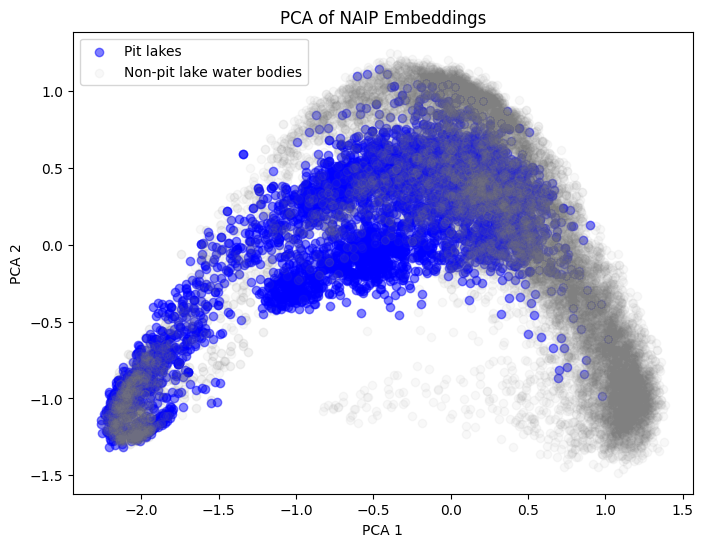

In [128]:
mn_pca = EmbeddingsPCA(mn_data)
PCAVisualization(mn_pca, column = 'mine', label1 = 'Pit lakes', label2 = 'Non-pit lake water bodies')

Relative variance in principal components: [0.19072938 0.11326633 0.09525669]


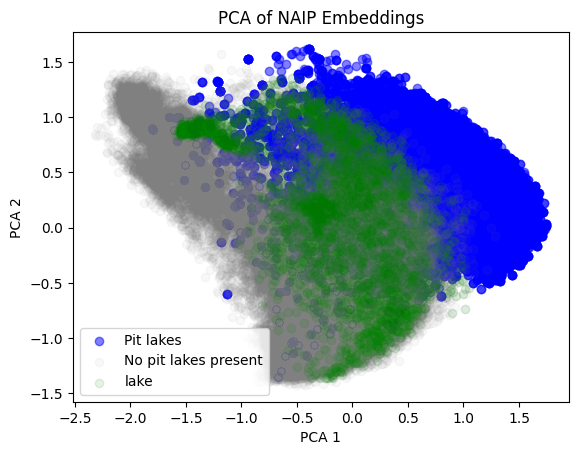

In [203]:
az_pca = EmbeddingsPCA(az_data)
ax = PCAVisualization(az_pca, 'mine','Pit lakes', 'No pit lakes present')

end_idx = len(az_pca)-1
start_idx = end_idx-len(az_lakes_chips)

ax.scatter(az_pca[start_idx:end_idx]['pca1'], 
                az_pca[start_idx:end_idx]['pca2'],
                color='green', label = 'lake', alpha = 0.1)

ax.legend()
plt.show()

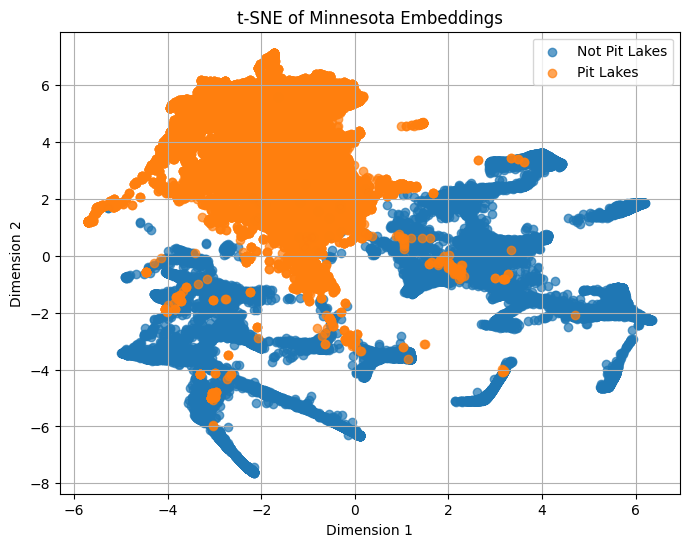

In [ ]:
#t-SNE of positive/negative embeddings

labels = data['mine'].values

tsne_data = np.vstack(data['embeddings'].values)

# Set up t-SNE
tsne = TSNE(n_components=2, perplexity=25, n_iter=250)
reduced_embeddings = tsne.fit_transform(tsne_data)

# Visualize the results
plt.figure(figsize=(8, 6))

custom_labels = {0: "Not Pit Lakes", 1: "Pit Lakes"}

for label in np.unique(labels):
    mask = labels == label
    plt.scatter(reduced_embeddings[mask, 1],
                reduced_embeddings[mask, 0],
                label=custom_labels.get(label, f"Label {label}"),
                alpha=0.7)

plt.title("t-SNE of Minnesota Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.legend()
plt.show()

In [208]:
az_data.iloc[0]['emb_idx']

0

In [187]:
y_test.sum()/len(y_test)

0.3811446546786234

### Build classification model to predict presence of pit lakes

In [213]:
# Mark positive samples 

def MarkSamples(data, polygons, pct):
    """ Mark as positive if intersection is greater than given % of area
    """
    # Get polygon of intersection for each chip
    data['emb_idx'] = data.index
    intersecting = gpd.overlay(data, polygons, how = 'intersection')
    intersecting = intersecting.dissolve(by='emb_idx')
    intersecting['area_overlap'] = intersecting.geometry.area

    # Match embedding index with embedding geometry
    data = data.merge(intersecting['area_overlap'], left_index = True, right_index = True, how='left')
    data.head()

    # Check intersection % and mark True/False
    for emb in data:
        print(emb)
        print(emb['area_overlap'])
        if emb['area_overlap'] / emb.geometry.area >= pct:
            emb['mine'] = 1
        elif emb['area_overlap'] == NaN:
            emb['mine'] = 0
        else: 
            emb['mine'] = 0
    
    return data

In [214]:
az_data_marked = MarkSamples(az_data, az_mines_intersect, 0.3)
az_data_marked.head()

geometry


TypeError: string indices must be integers, not 'str'

In [ ]:
# Split into train and test

train_embeddings =  np.vstack(az_data['embeddings'].values)
labels = np.array(az_data['mine'])
indices = az_data.index

X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

In [181]:
#DELETE
print(labels)

print(az_data['mine'].sum()/len(az_data))
print(az_data_crop['mine'].sum()/len(az_data_crop))

[1 1 1 ... 0 0 0]
0.38242854627618994
0.5330922656544006


In [204]:
# Train neural network model

X = X_train # training samples
y = y_train # class labels
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(16, 16, 16), max_iter = 500, random_state=1)

clf.fit(X, y)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(16, 16, 16), max_iter=500,
              random_state=1, solver='lbfgs')

In [205]:
predictions = clf.predict(X_test) 
print(f'Number of positive predictions: {predictions.sum()}')
print(f'Number of test samples: {len(X_test)}')

f1 = sklearn.metrics.f1_score(y_test, predictions)
print(f'F1: {f1}')

probabilities = clf.predict_proba(X_test)
print(f'Classes for probability: {clf.classes_}')

probabilities[:,1] # Probability of pit lake presence

Number of positive predictions: 8128
Number of test samples: 21299
F1: 0.9980302843776929
Classes for probability: [0 1]


array([1.52554904e-07, 1.00000000e+00, 1.57357201e-15, ...,
       9.58529305e-14, 1.84340586e-16, 1.00000000e+00])

,mine_prob,geometry
0,1.000000e+00,"POLYGON ((-110.95711 33.12356, -110.95711 33.1..."
1,1.000000e+00,"POLYGON ((-109.34105 33.14954, -109.34107 33.1..."
2,2.781313e-48,"POLYGON ((-113.99716 37.04071, -113.99722 37.0..."
3,1.000000e+00,"POLYGON ((-110.88737 33.41993, -110.88737 33.4..."
4,1.950502e-25,"POLYGON ((-109.2083 31.72253, -109.20832 31.72..."
...,...,...
15275,1.000000e+00,"POLYGON ((-114.16207 35.36057, -114.16212 35.3..."
15276,1.000000e+00,"POLYGON ((-109.35418 33.08948, -109.35421 33.0..."
15277,1.000000e+00,"POLYGON ((-109.36012 33.12419, -109.36015 33.1..."
15278,8.156004e-21,"POLYGON ((-112.87283 36.80289, -112.87279 36.8..."


In [184]:
# Write predictions and probabilities to shapefiles
az_pits_geom = az_data.geometry.loc[test_idx].reset_index(drop = True)
az_pits_pred = gpd.GeoDataFrame(predictions, columns = ['mines'], geometry=az_pits_geom, crs = 'EPSG:4326')
az_pits_probs = gpd.GeoDataFrame(probabilities[:,1], columns = ['mine_prob'], geometry=az_pits_geom, crs = 'EPSG:4326')

az_pits_pred.to_file('az_pits_pred_2')
az_pits_probs.to_file('az_pits_probs_2')

In [118]:
az_mines_intersect.to_file('mines_polys')

### REST OF NOTEBOOK IN DRAFT

#### Visualize a few mines

In [14]:
# Point over mine in Hibbing, Minnesota

lat, lon = 47.362228, -93.046666

# AOI around pt
""" aoi_as_list = [[-87.09601677899997,39.685325944000056],
      [-87.19601677899997,39.75325944000056],
      [-87.09601677899997,39.685325944000056],
      [-87.09601677899997,39.75325944000056],
      [-87.09601677899997,39.685325944000056]] """

""" aoi_as_dict = {
    "type": "Polygon",
    "coordinates": [aoi_as_list],
} """

# Date range
start = "2021-01-01"
end = "2021-12-31"

In [16]:
# Optimize GDAL settings for cloud optimized reading
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
os.environ["AWS_REQUEST_PAYER"] = "requester"

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 1e-3, lat - 1e-3, lon + 1e-3, lat + 1e-3),
    max_items=1,
    query={"eo:cloud_cover": {"lt": 10}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

Found 1 items


In [ ]:
# Retrieve the items
assets = []
assets_urls = []
item_latlons = []
item_bboxs = []

# Show 'visual' asset for true-color composite and create list of images
for item in items:
    asset = item.assets["visual"]
    assets.append(asset)
    assets_urls.append(asset.href)
    print(item.datetime)
    # Get centroids of images and create buffer polygons
    image_geom = Polygon(item.geometry['coordinates'][0])
    item_latlons.append(gpd.GeoDataFrame(geometry = [image_geom]).centroid)

for item in item_latlons:
    item_bboxs.append(item.buffer(0.2))
    print(item_bboxs)


2021-11-20 17:20:34.917000+00:00
[0    POLYGON ((-93.39776 47.35737, -93.39872 47.337...
dtype: geometry]


In [39]:
help(items[0])

Help on Item in module pystac.item object:

class Item(pystac.stac_object.STACObject, pystac.asset.Assets)
 |  Item(id: 'str', geometry: 'dict[str, Any] | None', bbox: 'list[float] | None', datetime: 'Datetime | None', properties: 'dict[str, Any]', start_datetime: 'Datetime | None' = None, end_datetime: 'Datetime | None' = None, stac_extensions: 'list[str] | None' = None, href: 'str | None' = None, collection: 'str | Collection | None' = None, extra_fields: 'dict[str, Any] | None' = None, assets: 'dict[str, Asset] | None' = None)
 |
 |  An Item is the core granular entity in a STAC, containing the core metadata
 |  that enables any client to search or crawl online catalogs of spatial 'assets' -
 |  satellite imagery, derived data, DEM's, etc.
 |
 |  Args:
 |      id : Provider identifier. Must be unique within the STAC.
 |      geometry : Defines the full footprint of the asset represented by this
 |          item, formatted according to
 |          `RFC 7946, section 3.1 (GeoJSON) <ht

In [35]:
item_bboxs_gpd = gpd.GeoDataFrame(geometry = item_bboxs[0],crs=4326)


In [ ]:
# Crop images - NEED TO FIX
from rasterio.mask import mask

with rasterio.open(assets_urls[0]) as src:
    cropped_image, cropped_transform = mask(src, item_bboxs_gpd[0].geometry, crop=True)

cropped_image_data = cropped_image 
cropped_image_transform = cropped_transform 

""" with rasterio.open("tests/data/RGB.byte.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta """

KeyError: 0

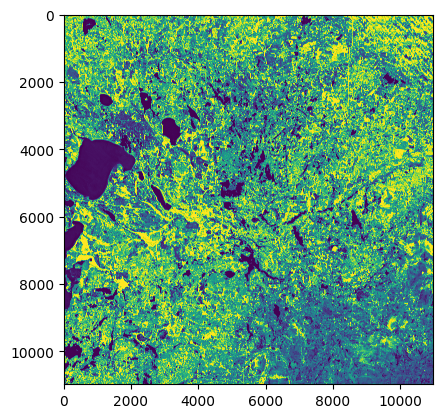

In [33]:
# Load and visualize the asset with rasterio

fig, ax = plt.subplots()

# Create image plotting function

src1 = rasterio.open(assets_urls[0])
#src2 = rasterio.open(assets_urls[1])
    
ax.imshow(src1.read(1))
#ax2.plt.imshow(src2.read(1))
plt.show()


### Find data for AOI
The first step is to find STAC items of imagery that we want to use to create embeddings. In this example we are going to use Earth Genome's composite dataset which comes with a great STAC catalog.

We are also going to create embeddings along time so that we have multiple embeddings for the same location at different moments in time.

In [ ]:
# Point over Nevada
# lat, lon = 39.145068721560506, -119.67465363188465

# AOI around Nevada
aoi_as_list = [[-119.1256714,39.6620962],
      [-119.1302491,39.5669496],
      [-118.959961,39.5500181],
      [-118.9544679,39.638862],
      [-119.1247559,39.6578851],
      [-119.1256714,39.6620962]]

aoi_as_dict = {
    "type": "Polygon",
    "coordinates": [aoi_as_list],
}

# Date range
start = "2018-07-01"
end = "2018-09-01"

In [32]:
# Optimize GDAL settings for cloud optimized reading
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
os.environ["AWS_REQUEST_PAYER"] = "requester"

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    intersects=aoi_as_dict, # CHANGED TO GET ONLY IMAGES INTERSECTING WITH AOI
    max_items=2,
    query={"eo:cloud_cover": {"lt": 10}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

Found 1 items


To speed up processing in this example, we limit the number of chips to 3 per Sentinel-2 scene. Remove this limit in a real use case.

In [ ]:
chips = []
datetimes = []
bboxs = []
chip_ids = []
item_ids = []

# Adjust desired chip dimension (pixels) 
# chip_dimension = int(224)
# stacchip.indexer.ChipIndexer.chip_size = chip_dimension # Edit default class chip size attribute
# Sentinel2Indexer.chip_size = chip_dimension

for item in items:
    print(f"Working on {item}")

    # Index the chips in the item
    indexer = Sentinel2Indexer(item)

    # Instanciate the chipper
    chipper = Chipper(indexer, assets=["red", "green", "blue", "nir", "scl"])

    # Get first chip for the "image" asset key
    for idx, (x, y, chip) in enumerate(chipper):
        #if idx > 3: # Remove this for full inference
        #    break
        del chip["scl"]
        chips.append(chip)
        datetimes.append(item.datetime)
        bboxs.append(indexer.get_chip_bbox(x, y))
        chip_ids.append((x, y))
        item_ids.append(item.id)

Working on <Item id=S2B_11SLD_20180825_1_L2A>


RasterioIOError: Read or write failed. /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/11/S/LD/2018/8/S2B_11SLD_20180825_1_L2A/B04.tif, band 1: IReadBlock failed at X offset 2, Y offset 1: TIFFReadEncodedTile() failed.

In [149]:
# Drop chips that don't intersect and corresponding chips, datetimes, chip IDs, and item IDs

bboxs_gdf = gpd.GeoDataFrame(geometry=bboxs)
aoi = Polygon(aoi_as_list)

mask = bboxs_gdf.intersects(aoi) # Create mask of bboxs of chips that intersect the AOI

chips = pd.Series(chips)[mask].tolist()
datetimes = pd.Series(datetimes)[mask].tolist()
bboxs = pd.Series(bboxs)[mask].tolist()
chip_ids = pd.Series(chip_ids)[mask].tolist()
item_ids = pd.Series(item_ids)[mask].tolist()

print("Number of chips that intersect with AOI: ")
print(len(chips))

Number of chips that intersect with AOI: 
4


In [150]:
pixels = np.array([np.array(list(chip.values())).squeeze() for chip in chips])
pixels.shape

(4, 4, 256, 256)

In [1]:
#Visualize chips

gpd.GeoDataFrame(geometry = bboxs).plot()

NameError: name 'gpd' is not defined

Prepare band metadata for passing it to the model

In [ ]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
# Retrieve the file content from the URL

url = (
    "https://raw.githubusercontent.com/Clay-foundation/model/main/configs/metadata.yaml"
)
response = requests.get(url, allow_redirects=True)

# Convert bytes to string
content = response.content.decode("utf-8")

# Load the yaml
content = yaml.safe_load(content)

metadata = Box(content)
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in chips[0].keys():
    mean.append(metadata[platform].bands.mean[band])
    std.append(metadata[platform].bands.std[band])
    waves.append(metadata[platform].bands.wavelength[band])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

Convert the band pixel data into the format for the model

In [ ]:
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding by normalizing centroids of chip bboxs
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

latlons = []

for bbox in bboxs:
    centroid = bbox.centroid
    lat, lon = centroid.y, centroid.x  # Extract lat, lon from centroid
    latlons.append(normalize_latlon(lat, lon))

#latlons = [normalize_latlon(lat, lon)] * len(times) # WHY DO WE WANT THE SAME THING REPEATED?
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Prep gsd
gsd = [10]

# Normalize pixels
pixels = transform(pixels)
pixels = pixels.astype(np.float32) # ADDED THIS BACK IN


In [ ]:
datacube = {
    "pixels": torch.tensor(pixels, dtype=torch.float32),
    "time": torch.tensor(np.hstack((week_norm, hour_norm)), dtype=torch.float32),
    "latlon": torch.tensor(np.hstack((lat_norm, lon_norm)), dtype=torch.float32),
    "waves": torch.tensor(waves, dtype=torch.float32),
    "gsd": torch.tensor(gsd, dtype=torch.float32),
}

In [ ]:
for k, v in datacube.items():
    print(k, v.shape)

pixels torch.Size([2, 4, 256, 256])
time torch.Size([2, 4])
latlon torch.Size([2, 4])
waves torch.Size([4])
gsd torch.Size([1])


### Clay Embedder

#### Load the embedder that is stored in ExportedProgram format using **cpu**.

#### Load and run the checkpoint of the model

In [36]:
import pytorch_lightning as pl
# Add LightningModule class inheritance to access load_from_checkpoint method
#class ClayMAE(pl.LightningModule): 
#    pass

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://huggingface.co/made-with-clay/Clay/resolve/main/clay_v1.5.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

RuntimeError: Unknown model (vit_large_patch14_reg4_dinov2)

In [ ]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

In [139]:
# Run the clay encoder
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = clay_encoder(*datacube)
# Get class embeddings
cls_embedding = unmsk_patch[:, 0, :]
# Print shape of class embeddings
cls_embedding.shape

NameError: name 'clay_encoder' is not defined

#### Load and run the exported cpu model

In [ ]:
# Get file from local exportedprogram format

! wget -q https://huggingface.co/made-with-clay/Clay/blob/main/v1.5/compiled/clay-v1.5-encoder-cpu.pt2

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
ep_embedder_cpu = torch.export.load("data/clay-v1.5-encoder-cpu.pt2").module()

Run the model with EP

In [ ]:
%%time
with torch.no_grad():
    embeddings = ep_embedder_cpu(datacube)
datacube["pixels"].shape, embeddings.shape

CPU times: total: 11.8 s
Wall time: 9.1 s


(torch.Size([2, 4, 256, 256]), torch.Size([2, 768]))

For each chip, we have an embedding of size `768`

#### Load the embedder that is stored in ExportedProgram format using **gpu**.

In [ ]:
!wget -q https://huggingface.co/made-with-clay/Clay/resolve/main/compiled/v1.0/clay-v1-encoder.pt2

In [ ]:
datacube = {k: v.to("cuda") for k, v in datacube.items()}
ep_embedder = torch.export.load("clay-v1-encoder.pt2").module()

In [ ]:
%%time
with torch.no_grad():
    embeddings = ep_embedder(datacube)
datacube["pixels"].shape, embeddings.shape

For each chip, we have an embedding of size `768`

#### Load the embedder that is stored in ONNX format using **cpu**.

In [ ]:
import onnxruntime as ort

In [ ]:
!wget -q https://huggingface.co/made-with-clay/Clay/resolve/main/compiled/v1.0/clay-v1-encoder-cpu.onnx

In [ ]:
datacube = {k: v.to("cpu") for k, v in datacube.items()}
onnx_embedder = ort.InferenceSession(
    "clay-v1-encoder-cpu.onnx", providers=["CPUExecutionProvider"]
)

In [ ]:
%%time
embeddings = onnx_embedder.run(
    [],
    {
        "cube": datacube["pixels"].numpy(),
        "time": datacube["time"].numpy(),
        "latlon": datacube["latlon"].numpy(),
        "waves": datacube["waves"].numpy(),
        "gsd": datacube["gsd"].numpy(),
    },
)[0]
embeddings.shape

For each chip, we have an embedding of size `768`

### Store the results

We create a table containing the embeddings, bounding box, the STAC item ID, the datetime of the image capture, and the chip x and y ids. Then we save that data to disk.

In [ ]:
# Write data to pyarrow table
index = {
    "datetimes": datetimes,
    "chip_ids": chip_ids,
    "item_ids": item_ids,
    "embeddings": [np.ascontiguousarray(dat) for dat in embeddings],
    "geometry": ga.as_geoarrow([dat.wkt for dat in bboxs]),
}
table = pa.table(index)
table

pyarrow.Table
datetimes: timestamp[us, tz=UTC]
chip_ids: list<item: int64>
  child 0, item: int64
item_ids: string
embeddings: list<item: float>
  child 0, item: float
geometry: extension<geoarrow.polygon<PolygonType>>
----
datetimes: [[2018-08-25 18:53:24.597000Z,2018-08-25 18:53:24.597000Z]]
chip_ids: [[[1,0],[2,0]]]
item_ids: [["S2B_11SLD_20180825_1_L2A","S2B_11SLD_20180825_1_L2A"]]
embeddings: [[[-0.12739897,0.06501336,-0.0043061064,0.093552634,0.15224756,...,0.048478447,-0.17023225,0.04420602,-0.18251786,-0.04366695],[-0.09462359,0.08339551,-0.030247303,0.114174575,0.17728658,...,0.044083178,-0.14688866,0.057765294,-0.17931639,-0.0330391]]]
geometry: [[[      -- is_valid: all not null
      -- child 0 type: double
[-118.9754053793589,-118.97146936387814,-119.15024167776343,-119.15453396559633,-118.9754053793589]
      -- child 1 type: double
[39.73345718524536,39.59514085820176,39.59196881845574,39.730269624751166,39.73345718524536]],[      -- is_valid: all not null
      -- child

In [ ]:
pq.write_table(table, "embeddings.parquet")

                         datetimes chip_ids                  item_ids  \
0 2018-08-25 18:53:24.597000+00:00   (1, 0)  S2B_11SLD_20180825_1_L2A   
1 2018-08-25 18:53:24.597000+00:00   (2, 0)  S2B_11SLD_20180825_1_L2A   

                                          embeddings  \
0  [-0.12739897, 0.06501336, -0.0043061064, 0.093...   
1  [-0.09462359, 0.08339551, -0.030247303, 0.1141...   

                                            geometry  
0  POLYGON ((-118.97541 39.73346, -118.97147 39.5...  
1  POLYGON ((-118.79625 39.73637, -118.79267 39.5...  


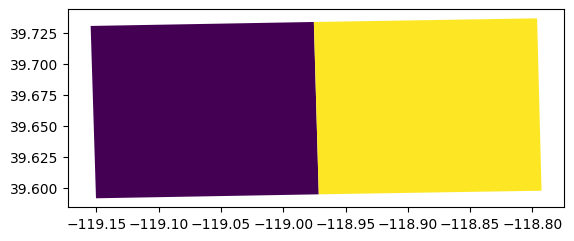

In [ ]:
# Convert into GeoDataFrame and visualize embeddings
index_gdf = gpd.GeoDataFrame(index, geometry = bboxs)
print(index_gdf.head())

# Visualize first dimension of embedding
index_gdf_first = gpd.GeoDataFrame(geometry = index_gdf['geometry'])
index_gdf_first['emb'] = index_gdf['embeddings'].apply(lambda x: x[0]) # Change 0 to visualize other dimensions

# Plot first embedding dimension
index_gdf_first.plot(column = 'emb')
plt.show()

In [ ]:
def plot_rgb(stack):
    """
    Plot the RGB bands of the given stack.

    Parameters:
    stack (xarray.DataArray): The input data array containing band information.
    """
    stack.sel(band=[1, 2, 3]).plot.imshow(rgb="band", vmin=0, vmax=2000, col_wrap=6)
    plt.show()